In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../../data/stats_by_game_played.csv", low_memory=False)
data["didnt_blank"] = (data["points_scored"] > 2).astype(int)

In [3]:
data.columns

Index(['gw', 'year', 'player', 'n_games_in_gw', 'points_scored',
       'playing_against_mean_difficulty', 'playing_against_mean_defence',
       'playing_against_mean_attack', 'playing_for_difficulty',
       'playing_for_defence', 'playing_for_attack', 'form', 'position',
       'creativity', 'influence', 'threat', 'selected', 'playing_chance',
       'birth_date', 'corners_and_free_kicks_order', 'penalties_order',
       'avg_minutes_when_playing', 'avg_points_when_playing',
       'avg_yellows_p_game_when_playing', 'avg_reds_p_game_when_playing',
       'avg_bps_p_game_when_playing', 'avg_goals_p_game_when_playing',
       'avg_assists_p_game_when_playing', 'avg_clean_sheets_when_playing',
       'avg_goals_conceded_when_playing', 'avg_starts_when_playing',
       'avg_saves_when_playing', 'didnt_blank'],
      dtype='object')

In [4]:
df = data.copy().drop(columns=["year", "gw", "player", "birth_date", "points_scored", "influence", "creativity", "threat"])


In [5]:
df.head()

,n_games_in_gw,playing_against_mean_difficulty,playing_against_mean_defence,playing_against_mean_attack,playing_for_difficulty,playing_for_defence,playing_for_attack,form,position,selected,...,avg_yellows_p_game_when_playing,avg_reds_p_game_when_playing,avg_bps_p_game_when_playing,avg_goals_p_game_when_playing,avg_assists_p_game_when_playing,avg_clean_sheets_when_playing,avg_goals_conceded_when_playing,avg_starts_when_playing,avg_saves_when_playing,didnt_blank
0,1,2.0,1190.0,1170.0,4.0,1160.0,1160.0,0.00,2,0.8,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
1,1,2.0,1110.0,1090.0,2.0,1080.0,1110.0,0.25,2,0.8,...,1.00,0.0,6.0,0.0,0.0,0.0,1.00,0.0,0.0,0
2,2,2.0,1205.0,1195.0,4.0,1080.0,1110.0,0.00,2,0.8,...,0.50,0.0,4.5,0.0,0.0,0.0,0.50,0.0,0.0,1
3,1,2.0,1100.0,1130.0,2.0,1080.0,1110.0,1.00,2,0.8,...,0.25,0.0,10.0,0.0,0.0,0.0,0.75,0.0,0.0,0
4,1,2.0,1080.0,1150.0,3.0,1160.0,1160.0,1.20,2,0.8,...,0.20,0.0,10.4,0.0,0.0,0.0,0.80,0.0,0.0,1


Class counts (train before): {0: 23514, 1: 10986}
Class counts (train after):  {1: 10986, 0: 10986}


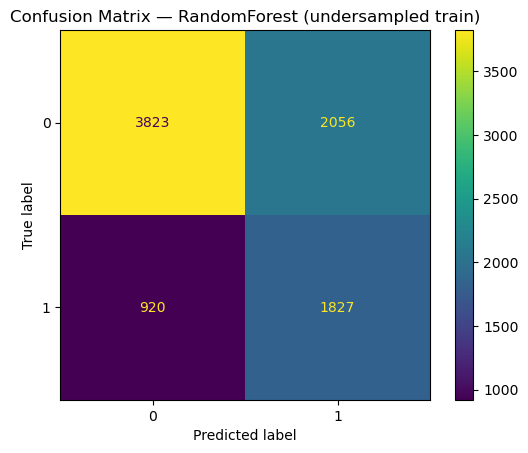

              precision    recall  f1-score   support

           0      0.806     0.650     0.720      5879
           1      0.471     0.665     0.551      2747

    accuracy                          0.655      8626
   macro avg      0.638     0.658     0.635      8626
weighted avg      0.699     0.655     0.666      8626



In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keep y as a Series so we can index by boolean masks
y = df["didnt_blank"]
X = df.drop(columns=["didnt_blank"])

# Split first (test set stays representative, not balanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- Random undersample majority class on TRAIN only ----
n_pos = (y_train == 1).sum()
pos_idx = y_train[y_train == 1].index
neg_idx = y_train[y_train == 0].index

# Sample equal number of negatives as positives
neg_idx_sample = np.random.default_rng(42).choice(neg_idx, size=n_pos, replace=False)

# Combine and shuffle
keep_idx = np.concatenate([pos_idx.values, neg_idx_sample])
rng = np.random.default_rng(42)
rng.shuffle(keep_idx)

X_train_bal = X_train.loc[keep_idx]
y_train_bal = y_train.loc[keep_idx]

print("Class counts (train before):", y_train.value_counts().to_dict())
print("Class counts (train after): ", y_train_bal.value_counts().to_dict())

# ---- Train model on balanced training set ----
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_bal, y_train_bal)

# ---- Evaluate on untouched test set ----
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix — RandomForest (undersampled train)")
plt.show()

print(classification_report(y_test, y_pred, digits=3))



                            feature  importance
9                          selected    0.155497
14          avg_points_when_playing    0.082098
17      avg_bps_p_game_when_playing    0.071941
0                     n_games_in_gw    0.065577
7                              form    0.063041
13         avg_minutes_when_playing    0.060335
2      playing_against_mean_defence    0.058717
3       playing_against_mean_attack    0.048592
20    avg_clean_sheets_when_playing    0.046728
4            playing_for_difficulty    0.045953
6                playing_for_attack    0.037484
5               playing_for_defence    0.036538
21  avg_goals_conceded_when_playing    0.034862
1   playing_against_mean_difficulty    0.031820
15  avg_yellows_p_game_when_playing    0.024759
18    avg_goals_p_game_when_playing    0.024579
19  avg_assists_p_game_when_playing    0.024462
22          avg_starts_when_playing    0.020921
8                          position    0.019707
11     corners_and_free_kicks_order    0

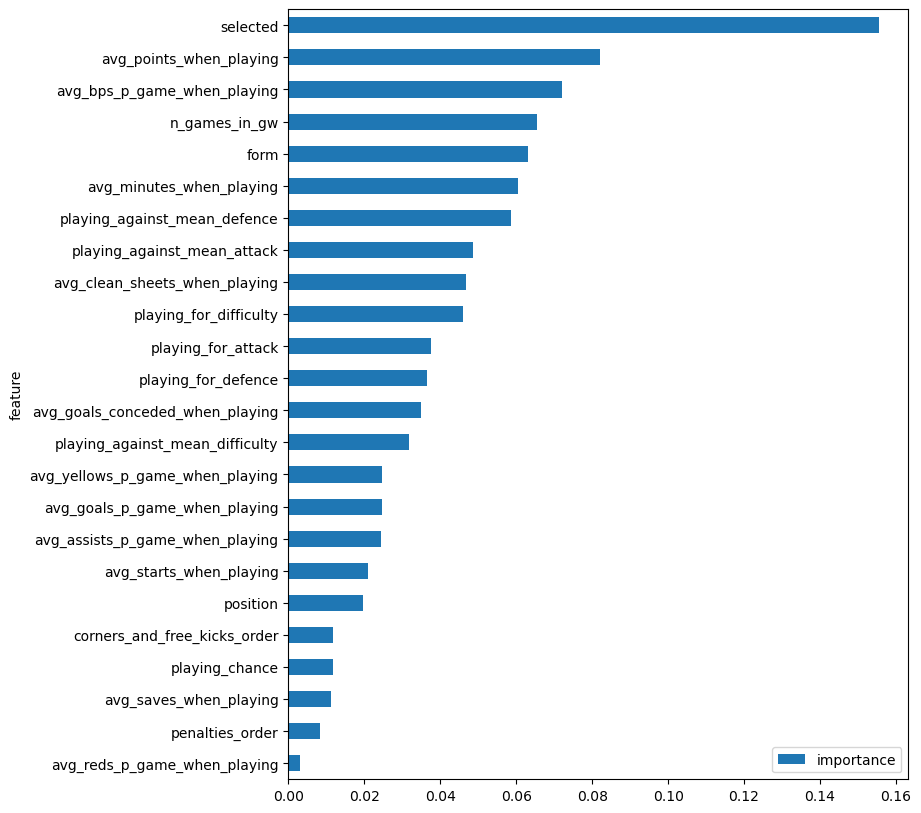

In [7]:
import pandas as pd
import numpy as np

importances = clf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp_df.head(20))

feat_imp_df.plot(kind="barh", x="feature", y="importance", figsize=(8, 10))
plt.gca().invert_yaxis()
plt.show()


In [8]:
import joblib

# Save the trained model
joblib.dump(clf, "random_forest_model.pkl")

# Later, load it back
clf_loaded = joblib.load("random_forest_model.pkl")

# Verify it works
print(clf_loaded.predict(X_test[:5]))


[1 1 1 0 0]


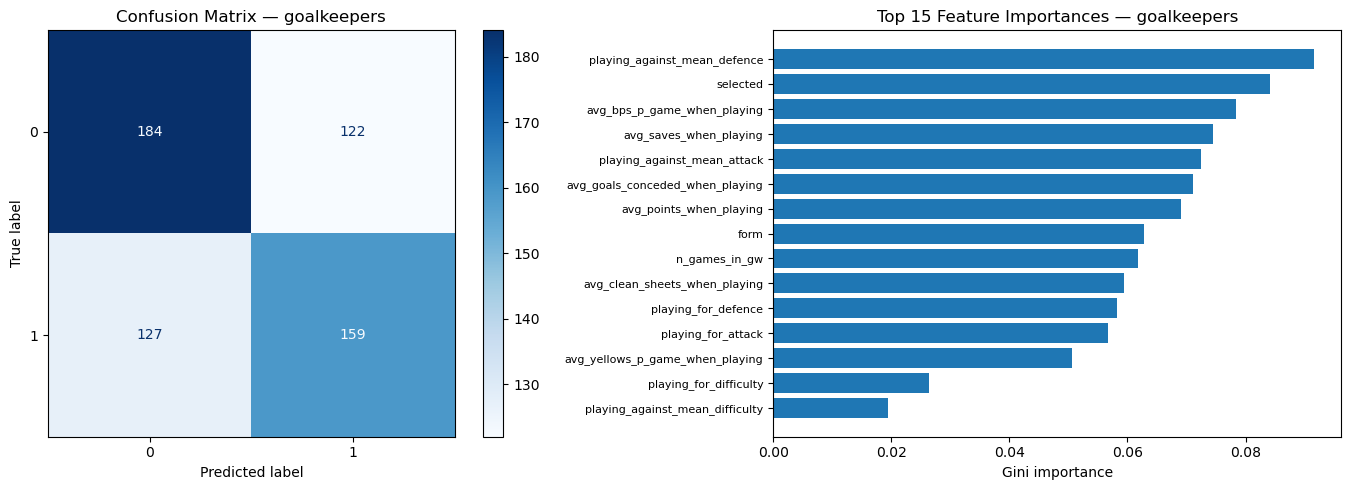


== Goalkeepers ==
              precision    recall  f1-score   support

           0      0.592     0.601     0.596       306
           1      0.566     0.556     0.561       286

    accuracy                          0.579       592
   macro avg      0.579     0.579     0.579       592
weighted avg      0.579     0.579     0.579       592



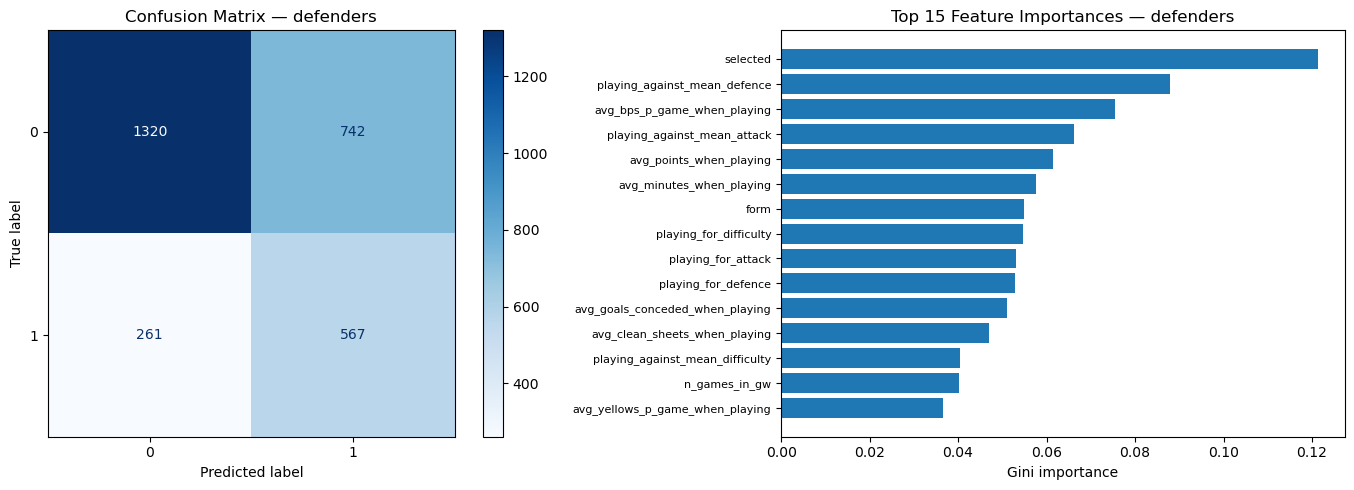


== Defenders ==
              precision    recall  f1-score   support

           0      0.835     0.640     0.725      2062
           1      0.433     0.685     0.531       828

    accuracy                          0.653      2890
   macro avg      0.634     0.662     0.628      2890
weighted avg      0.720     0.653     0.669      2890



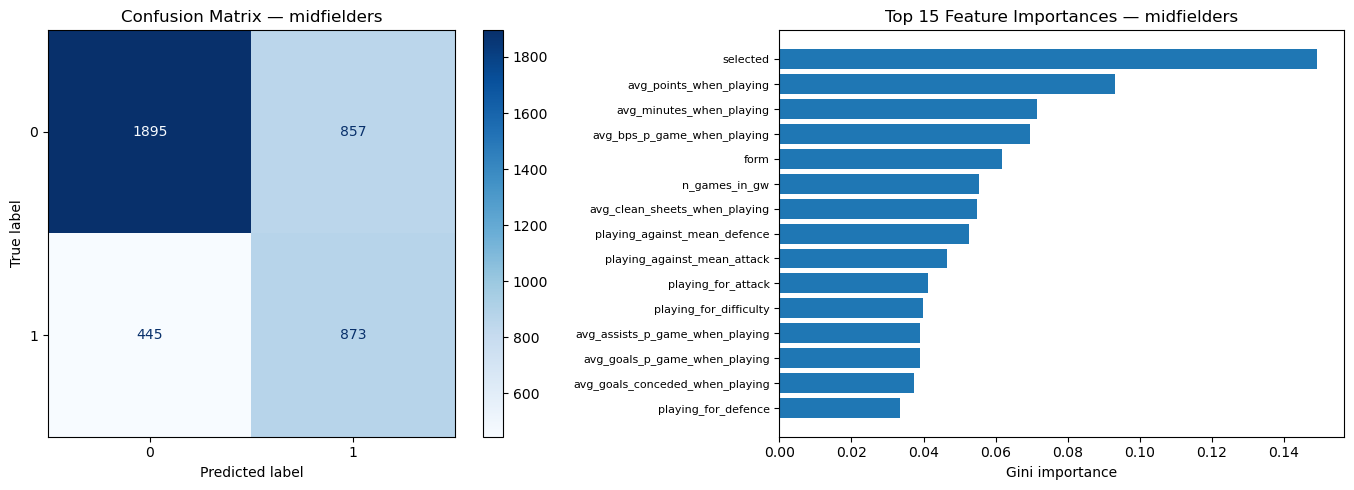


== Midfielders ==
              precision    recall  f1-score   support

           0      0.810     0.689     0.744      2752
           1      0.505     0.662     0.573      1318

    accuracy                          0.680      4070
   macro avg      0.657     0.675     0.659      4070
weighted avg      0.711     0.680     0.689      4070



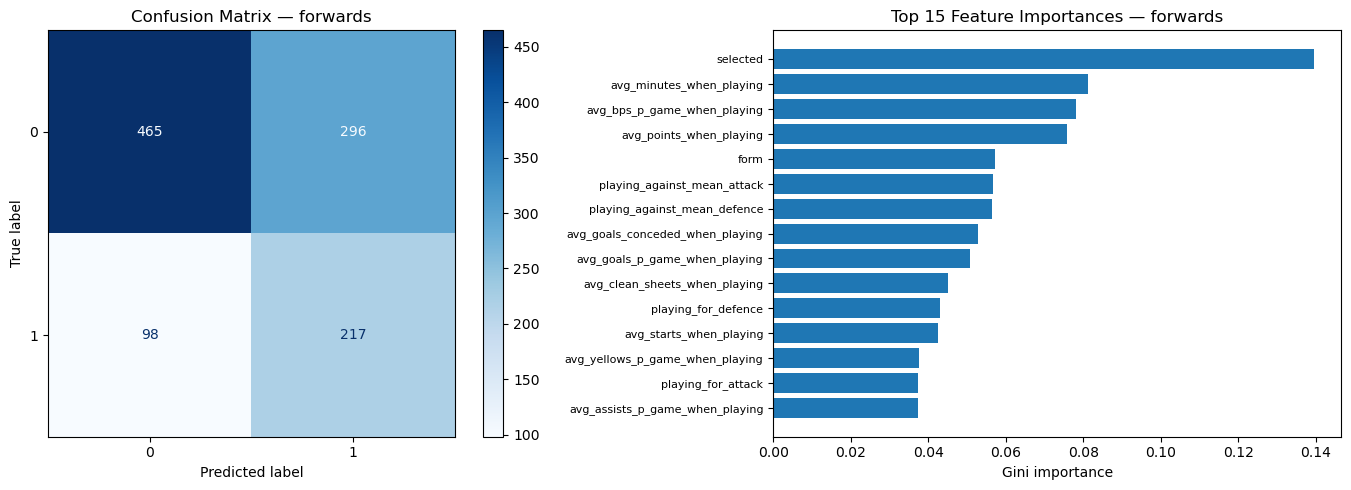


== Forwards ==
              precision    recall  f1-score   support

           0      0.826     0.611     0.702       761
           1      0.423     0.689     0.524       315

    accuracy                          0.634      1076
   macro avg      0.624     0.650     0.613      1076
weighted avg      0.708     0.634     0.650      1076



In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pos_map = {
    1: "goalkeepers",
    2: "defenders",
    3: "midfielders",
    4: "forwards"
}

TOPK = 15  # how many features to show on the right
models = []

from sklearn.utils import resample

for i in range(1, 5):
    pos_df = df[df["position"] == i].copy()

    # Target and features
    y_pos = pos_df["didnt_blank"]
    X_pos = pos_df.drop(columns=["didnt_blank"])

    # Keep only numeric features
    num_cols = X_pos.select_dtypes(include=[np.number]).columns.tolist()
    if "position" in num_cols:
        num_cols.remove("position")
    X_pos = X_pos[num_cols]

    # Train/test split
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
        X_pos, y_pos, test_size=0.2, random_state=42, stratify=y_pos
    )

    # ---- Balance the training set (undersample majority) ----
    train_df = X_train_pos.copy()
    train_df["target"] = y_train_pos

    # Separate majority/minority
    df_majority = train_df[train_df["target"] == 0]
    df_minority = train_df[train_df["target"] == 1]

    # Downsample majority to match minority count
    df_majority_down = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )

    train_bal = pd.concat([df_majority_down, df_minority])
    # Shuffle
    train_bal = train_bal.sample(frac=1, random_state=42)

    y_train_bal = train_bal["target"]
    X_train_bal = train_bal.drop(columns=["target"])

    # Impute NaNs
    imputer = SimpleImputer(strategy="mean")
    X_train_bal_imp = pd.DataFrame(imputer.fit_transform(X_train_bal), columns=num_cols)
    X_test_pos_imp = pd.DataFrame(imputer.transform(X_test_pos), columns=num_cols)

    # Train model
    clf_pos = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    clf_pos.fit(X_train_bal_imp, y_train_bal)
    models.append(clf_pos)

    # Predictions
    y_pred_pos = clf_pos.predict(X_test_pos_imp)

    # Plot CM + feature importances
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ConfusionMatrixDisplay.from_estimator(clf_pos, X_test_pos_imp, y_test_pos, ax=axes[0], cmap="Blues")
    axes[0].set_title(f"Confusion Matrix — {pos_map[i]}")

    importances = clf_pos.feature_importances_
    fi = pd.DataFrame({"feature": num_cols, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(15).iloc[::-1]
    axes[1].barh(fi["feature"], fi["importance"])
    axes[1].set_title(f"Top 15 Feature Importances — {pos_map[i]}")
    axes[1].set_xlabel("Gini importance")
    axes[1].tick_params(axis="y", labelsize=8)

    plt.tight_layout()
    plt.show()

    print(f"\n== {pos_map[i].title()} ==")
    print(classification_report(y_test_pos, y_pred_pos, digits=3))



In [12]:
for i, model in enumerate(models):
    import joblib
    joblib.dump(clf, f"classifiers/{pos_map[i + 1]}.pkl")

